<a href="https://colab.research.google.com/github/cinnaavox/TravelTide-Project/blob/main/TravelTide_%E2%80%93_Week_3_Dashboard_Perk_Segmentation_(Executive_View).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-2733668488.py:173: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax8.boxplot(data, labels=labels, vert=True, showfliers=False)
/tmp/ipython-input-2733668488.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


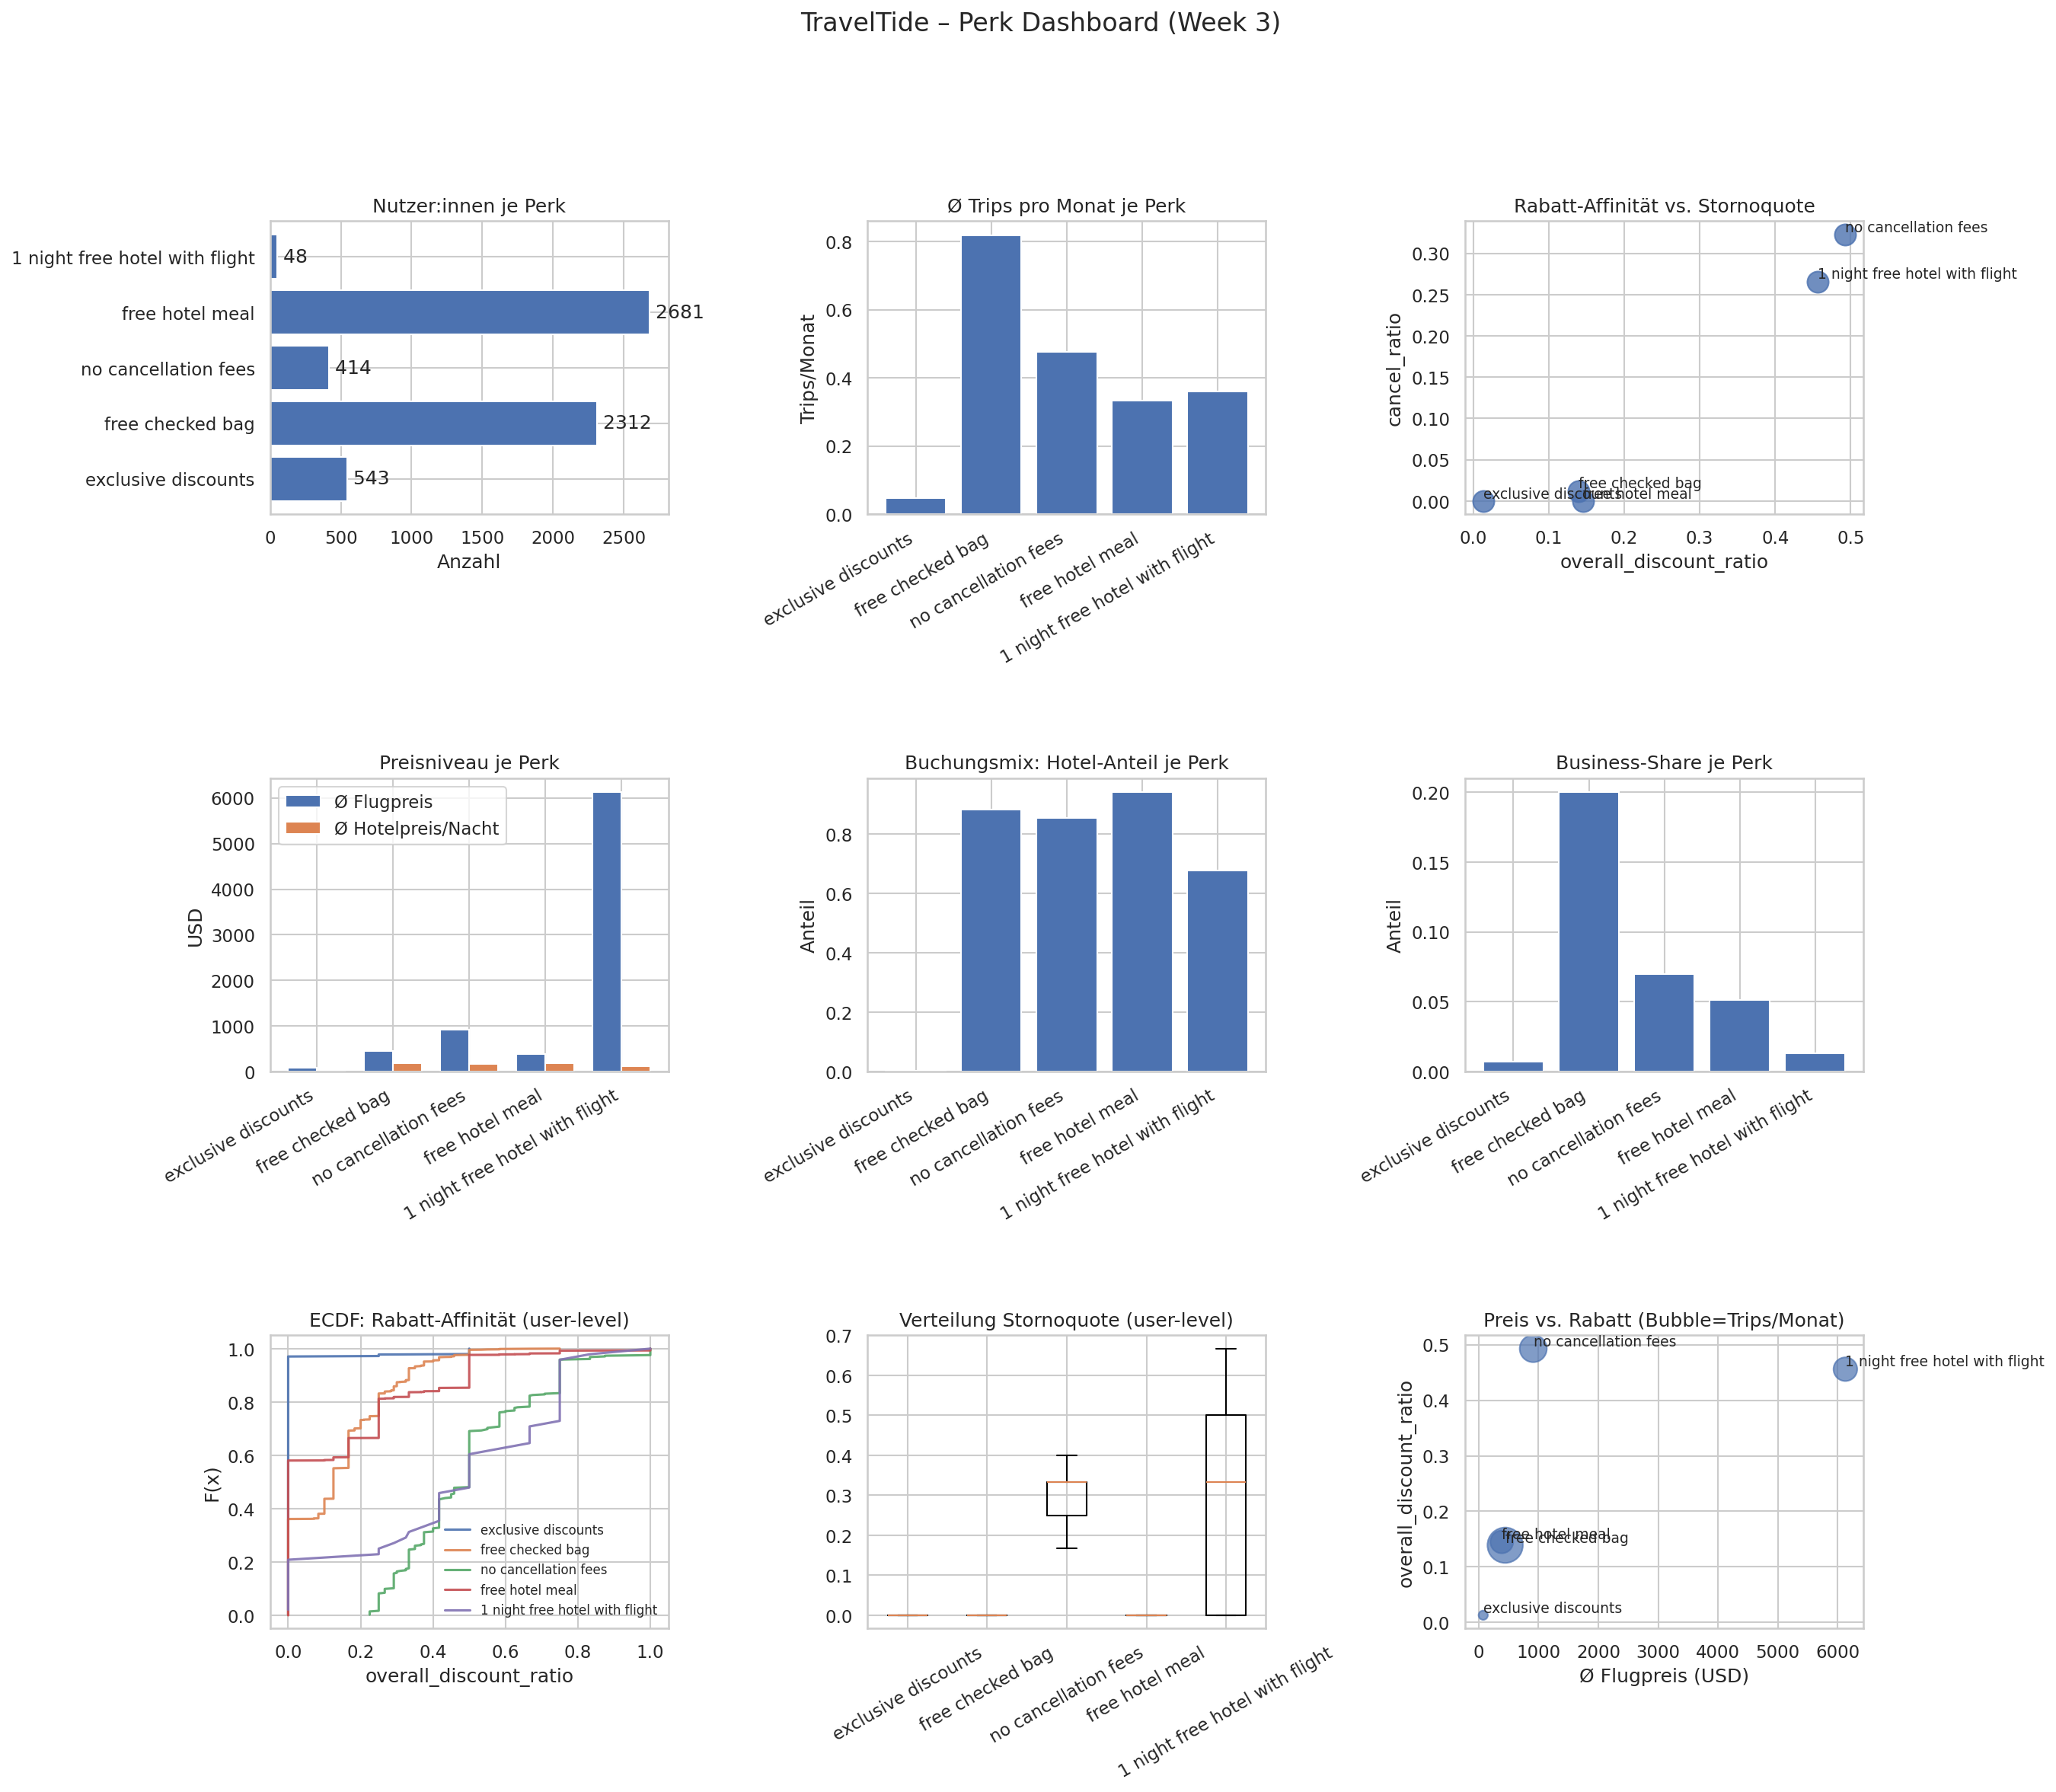


Exportierte Dateien in: /content/week3_dashboard_exports
 • 00_dashboard_full.png
 • 01_users_per_perk.png
 • 02_cluster_perk_heatmap.png
 • 02_trips_per_month_perk.png
 • 03_discount_vs_cancel.png
 • 03_radar_profiles.png
 • 04_bubble_discount_vs_trips.png
 • 04_price_levels_perk.png
 • 05_hotel_share_perk.png
 • 05_price_comparison.png
 • 06_business_share_perk.png
 • 07_ecdf_discount.png
 • 08_box_cancel.png
 • 09_bubble_price_discount.png
 • chart_01.png
 • chart_02.png
 • chart_03.png
 • chart_04.png
 • chart_05.png
 • chart_06.png
 • chart_07.png
 • chart_08.png
 • chart_09.png
 • chart_10.png
 • dashboard_3x3.png


In [ ]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

EXPORT_DIR = "week3_dashboard_exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

def _maybe_load_user_base():

    try:

        path = find_path("user_base_week3_extended.csv") if 'find_path' in globals() else None
        if path and os.path.exists(path):
            return pd.read_csv(path)

        for d in [".","/content","/content/drive/MyDrive","/mnt/data"]:
            p = os.path.join(d, "user_base_week3_extended.csv")
            if os.path.exists(p):
                return pd.read_csv(p)
    except Exception:
        pass
    return None

user_base = _maybe_load_user_base()

# Perk-Labels in fixer Reihenfolge
perk_order = [
    "exclusive discounts",
    "free checked bag",
    "no cancellation fees",
    "free hotel meal",
    "1 night free hotel with flight",
]

# Helper: sichere Reihenfolge & fehlende Perks abfangen
def _align_index(df, col_name="assigned_perk"):
    present = [p for p in perk_order if p in df.index]
    missing = [p for p in perk_order if p not in df.index]
    if missing:
        print("ℹ️  (Hinweis) Perks ohne Daten:", missing)
    return df.loc[present]

# 1) Vorbereitungen (Counts, perk-level Kennzahlen)
# Nutzer:innen je Perk (für Kachel 1)
perk_counts = df_perks["assigned_perk"].value_counts().reindex(perk_order, fill_value=0)

# Perk-level Kennzahlen (aus perk_summary)
ps = perk_summary.copy()
if "assigned_perk" in ps.columns:
    ps = ps.set_index("assigned_perk")
ps = _align_index(ps)

# Preis-Daten eventuell nicht für alle Perks vorhanden → robust
has_flight_price = "avg_flight_price" in ps.columns
has_hotel_price  = "avg_hotel_price_per_night" in ps.columns

# 2) User-Level für Verteilungen (Trips/Monat, Discount, Cancel)
df_user = None
if user_base is not None:
    # benötigte Spalten + Merge auf user_id
    needed = [
        "user_id","u_trips_per_month","overall_discount_ratio",
        "cancel_ratio","avg_flight_price","avg_hotel_price_per_night"
    ]
    cols = [c for c in needed if c in user_base.columns]
    if {"user_id"}.issubset(set(cols)):
        df_user = user_base[cols].merge(df_perks, on="user_id", how="inner")
        # nur relevante Perks
        df_user = df_user[df_user["assigned_perk"].isin(perk_order)]

# 3) Figure-Layout (3×3)
plt.close("all")
fig = plt.figure(figsize=(18, 16), constrained_layout=False)
gs  = GridSpec(nrows=3, ncols=3, figure=fig, hspace=0.9, wspace=0.5)

# Kachel 1: Nutzer:innen je Perk (horizontal)
ax1 = fig.add_subplot(gs[0, 0])
ax1.barh(perk_counts.index, perk_counts.values)
ax1.set_title("Nutzer:innen je Perk")
ax1.set_xlabel("Anzahl")
for y, v in enumerate(perk_counts.values):
    ax1.text(v, y, f" {int(v)}", va="center")
fig.savefig(os.path.join(EXPORT_DIR, "01_users_per_perk.png"), dpi=150, bbox_inches="tight")

# Kachel 2: Ø Trips/Monat je Perk
ax2 = fig.add_subplot(gs[0, 1])
if "u_trips_per_month" in ps.columns:
    vals = ps["u_trips_per_month"].reindex(perk_order).fillna(0)
    ax2.bar(range(len(vals)), vals.values)
    ax2.set_xticks(range(len(vals)))
    ax2.set_xticklabels(vals.index, rotation=30, ha="right")
    ax2.set_title("Ø Trips pro Monat je Perk")
    ax2.set_ylabel("Trips/Monat")
fig.savefig(os.path.join(EXPORT_DIR, "02_trips_per_month_perk.png"), dpi=150, bbox_inches="tight")

# Kachel 3: Rabatt-Affinität vs. Stornoquote (perk-level)
ax3 = fig.add_subplot(gs[0, 2])
if {"overall_discount_ratio","cancel_ratio"}.issubset(ps.columns):
    x = ps["overall_discount_ratio"].values
    y = ps["cancel_ratio"].values
    ax3.scatter(x, y, s=180, alpha=0.8)
    for xi, yi, lab in zip(x, y, ps.index):
        ax3.text(xi, yi, lab, fontsize=9, ha="left", va="bottom")
    ax3.set_xlabel("overall_discount_ratio")
    ax3.set_ylabel("cancel_ratio")
    ax3.set_title("Rabatt-Affinität vs. Stornoquote")
fig.savefig(os.path.join(EXPORT_DIR, "03_discount_vs_cancel.png"), dpi=150, bbox_inches="tight")

# Kachel 4: Preisniveau (Doppelbalken)
ax4 = fig.add_subplot(gs[1, 0])
if has_flight_price or has_hotel_price:
    idx = np.arange(len(ps.index))
    width = 0.38
    if has_flight_price:
        ax4.bar(idx - width/2, ps["avg_flight_price"], width, label="Ø Flugpreis")
    if has_hotel_price:
        ax4.bar(idx + width/2, ps["avg_hotel_price_per_night"], width, label="Ø Hotelpreis/Nacht")
    ax4.set_xticks(idx); ax4.set_xticklabels(ps.index, rotation=30, ha="right")
    ax4.set_title("Preisniveau je Perk"); ax4.set_ylabel("USD"); ax4.legend()
fig.savefig(os.path.join(EXPORT_DIR, "04_price_levels_perk.png"), dpi=150, bbox_inches="tight")

# Kachel 5: Buchungsmix (Hotelanteil)
ax5 = fig.add_subplot(gs[1, 1])
if "hotel_ratio" in ps.columns:
    vals = ps["hotel_ratio"].reindex(perk_order).fillna(0)
    ax5.bar(range(len(vals)), vals.values)
    ax5.set_xticks(range(len(vals))); ax5.set_xticklabels(vals.index, rotation=30, ha="right")
    ax5.set_title("Buchungsmix: Hotel-Anteil je Perk"); ax5.set_ylabel("Anteil")
fig.savefig(os.path.join(EXPORT_DIR, "05_hotel_share_perk.png"), dpi=150, bbox_inches="tight")

# Kachel 6: Business-Share je Perk
ax6 = fig.add_subplot(gs[1, 2])
if "business_trip_share" in ps.columns:
    vals = ps["business_trip_share"].reindex(perk_order).fillna(0)
    ax6.bar(range(len(vals)), vals.values)
    ax6.set_xticks(range(len(vals))); ax6.set_xticklabels(vals.index, rotation=30, ha="right")
    ax6.set_title("Business-Share je Perk"); ax6.set_ylabel("Anteil")
fig.savefig(os.path.join(EXPORT_DIR, "06_business_share_perk.png"), dpi=150, bbox_inches="tight")

# Kachel 7: ECDF Rabatt-Affinität (user-level)
ax7 = fig.add_subplot(gs[2, 0])
if (df_user is not None) and ("overall_discount_ratio" in df_user.columns):
    for p in perk_order:
        d = df_user.loc[df_user["assigned_perk"]==p, "overall_discount_ratio"].dropna().values
        if len(d)==0: continue
        x = np.sort(d); y = np.arange(1, len(x)+1)/len(x)
        ax7.plot(x, y, label=p, alpha=0.9)
    ax7.set_title("ECDF: Rabatt-Affinität (user-level)")
    ax7.set_xlabel("overall_discount_ratio"); ax7.set_ylabel("F(x)")
    ax7.legend(fontsize=8, ncols=1, loc="lower right", frameon=False)
fig.savefig(os.path.join(EXPORT_DIR, "07_ecdf_discount.png"), dpi=150, bbox_inches="tight")

# Kachel 8: Verteilung Stornoquote (user-level, Boxplots)
ax8 = fig.add_subplot(gs[2, 1])
if (df_user is not None) and ("cancel_ratio" in df_user.columns):
    data = [df_user.loc[df_user["assigned_perk"]==p, "cancel_ratio"].dropna().values for p in perk_order]
    labels = [p for p,d in zip(perk_order, data) if len(d)>0]
    data   = [d for d in data if len(d)>0]
    if data:
        ax8.boxplot(data, labels=labels, vert=True, showfliers=False)
        ax8.set_title("Verteilung Stornoquote (user-level)")
        ax8.tick_params(axis='x', rotation=30)
fig.savefig(os.path.join(EXPORT_DIR, "08_box_cancel.png"), dpi=150, bbox_inches="tight")

# Kachel 9: Bubble — Preis vs. Rabatt (perk-level, Größe=Trips/Monat)
ax9 = fig.add_subplot(gs[2, 2])
needed_cols = {"avg_flight_price","overall_discount_ratio","u_trips_per_month"}
if needed_cols.issubset(ps.columns):
    xx = ps["avg_flight_price"].values
    yy = ps["overall_discount_ratio"].values
    ss = (ps["u_trips_per_month"].values + 0.01) * 600  # Bubble-Größe
    ax9.scatter(xx, yy, s=ss, alpha=0.7)
    for xi, yi, li in zip(xx, yy, ps.index):
        ax9.text(xi, yi, li, fontsize=9, ha="left", va="bottom")
    ax9.set_xlabel("Ø Flugpreis (USD)"); ax9.set_ylabel("overall_discount_ratio")
    ax9.set_title("Preis vs. Rabatt (Bubble=Trips/Monat)")
fig.savefig(os.path.join(EXPORT_DIR, "09_bubble_price_discount.png"), dpi=150, bbox_inches="tight")

# Gesamtdashboard speichern
fig.suptitle("TravelTide – Perk Dashboard (Week 3)", fontsize=16, y=0.995)
plt.tight_layout()
fig.savefig(os.path.join(EXPORT_DIR, "00_dashboard_full.png"), dpi=150, bbox_inches="tight")
plt.show()

print("\nExportierte Dateien in:", os.path.abspath(EXPORT_DIR))
for f in sorted(os.listdir(EXPORT_DIR)):
    print(" •", f)
